# Make sure Lanczos and pre-lanczos implementation of CASE produces the same outcomes

In [1]:
import numpy as np
from scipy.sparse.linalg import eigsh
from sklearn.preprocessing import normalize

from graspologic.utils import import_graph, to_laplacian, is_almost_symmetric
from graspologic.embed.base import BaseSpectralEmbed

class CASEOld(BaseSpectralEmbed):

    def __init__(
        self,
        alpha=None,
        embedding_alg="assortative",
        n_components=None,
        n_elbows=2,
        check_lcc=False,
    ):
        super().__init__(
            n_components=n_components,
            n_elbows=n_elbows,
            check_lcc=check_lcc,
            concat=False,
        )

        if embedding_alg not in {"assortative", "non-assortative"}:
            msg = "embedding_alg must be in {assortative, non-assortative}."
            raise ValueError(msg)
        self.embedding_alg = embedding_alg

        if not ((alpha is None) or isinstance(alpha, (float, int))):
            msg = "alpha must be in {None, float, int}."
            raise TypeError(msg)

        self.alpha = alpha
        self.latent_right_ = None
        self.is_fitted_ = False

    def fit(self, network, y=None):
        """
        Fit a CASE model to an input graph, along with its covariates. Depending on the
        embedding algorithm, we embed
        .. math:: L_ = LL + \alpha YY^T
        .. math:: L_ = L + \alpha YY^T
        where :math:`\alpha` is a tuning parameter which makes the leading eigenvalues
        of the two summands the same. Here, :math:`L` is the regularized
        graph Laplacian, and :math:`Y` is a matrix of covariates for each node.
        Parameters
        ----------
        network : tuple or list of np.ndarrays
            Contains the tuple (A, Y), where A is an adjacency matrix and Y is the
            matrix of covariates.
            A : array-like or networkx.Graph
                Input graph to embed. See graspologic.utils.import_graph
            Y : array-like, shape (n_vertices, n_covariates)
                Covariate matrix. Each node of the graph is associated with a set of
                `d` covariates. Row `i` of the covariates matrix corresponds to node
                `i`, and the number of columns are the number of covariates.
        y: Ignored
        Returns
        -------
        self : object
            Returns an instance of self.
        """

        # setup
        if not isinstance(network, (tuple, list)):
            msg = "Network should be a tuple-like object of (graph, covariates)."
            raise TypeError(msg)
        if len(network) != 2:
            msg = "Network should be a tuple-like object of (graph, covariates)."
            raise ValueError(msg)

        graph, covariates = network
        A = import_graph(graph)
        if A.shape[0] != A.shape[1]:
            raise ValueError("Graph should be square")
        if not is_almost_symmetric(A):
            raise ValueError("Fit an undirected graph")

        # Create regularized Laplacian, scale covariates to unit norm
        L = to_laplacian(A, form="R-DAD")
        Y = covariates.copy()
        if Y.ndim == 1:
            Y = Y[:, np.newaxis]
        Y = normalize(Y, axis=0)

        # change params based on tuning algorithm
        if self.embedding_alg == "assortative":
            LL = L.copy()
            YYt = Y @ Y.T
        elif self.embedding_alg == "non-assortative":
            LL = L @ L
            YYt = Y @ Y.T

        # Get weight and create embedding matrix
        self._get_tuning_parameter(LL, YYt)
        L_ = (LL + self.alpha_ * (YYt)).astype(float)

        # Dimensionality reduction with SVD
        self._reduce_dim(L_)

        self.is_fitted_ = True
        return self

    def _get_tuning_parameter(self, LL, YYt):
        """
        Find the alpha which causes the leading eigenspace of LL and YYt to be the same.
        Parameters
        ----------
        LL : array
            The regularized graph Laplacian (assortative)
            The squared regularized graph Laplacian (non-assortative)
        YYt : array
            Y@Y.T, where Y is the covariate matrix.
        Returns
        -------
        alpha : float
            Tuning parameter which normalizes the leading eigenspace of LL and YYt.
        """
        # setup
        if self.alpha is not None:
            self.alpha_ = self.alpha
            return self

        # calculate bounds
        (L_top,) = eigsh(LL, return_eigenvectors=False, k=1)
        (Y_top,) = eigsh(YYt, return_eigenvectors=False, k=1)

        # just use the ratio of the leading eigenvalues for the
        # tuning parameter, or the closest value in its possible range.
        self.alpha_ = np.float(L_top / Y_top)

        return self

In [15]:
import numpy as np
from scipy.sparse.linalg import LinearOperator, eigsh
from scipy.stats import beta
import pandas as pd
import seaborn as sns
from graspologic.simulations import sbm
from graspologic.utils import to_laplacian
from graspologic.embed import CovariateAssistedEmbed as CASE
from time import time
import matplotlib.pyplot as plt

import warnings; warnings.filterwarnings("ignore")


np.set_printoptions(suppress=True)

def plot_latents(latent_positions, *, title=None, labels=None, ax=None, legend=False,
                 fontdict=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    plot = sns.scatterplot(latent_positions[:, 0], latent_positions[:, 1], hue=labels, 
                           s=10, ax=ax, palette="Set1", color='k', **kwargs)
    if title is not None:
        plot.set_title(title, wrap=True, fontdict=fontdict, loc="left");
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    if legend:
        ax.legend(loc="upper right", title="Community")
    elif not legend and np.any(labels):
        ax.get_legend().remove()
    
    return plot

def make_community(a, b, n=500):
    return beta.rvs(a, b, size=(n, 5))

def gen_covariates(n):
    c1 = make_community(2, 5, n=n)
    c2 = make_community(2, 2, n=n)

    covariates = np.vstack((c1, c2))
    return covariates

def gen_network(n):
    P = np.array([[.08, .02], [.02, .08]])
    A = sbm([n//2, n//2], P, return_labels=True)
    Y = gen_covariates(n=n//2)
    return A, Y

(A, labels), Y = gen_network(200)
case = CASE(n_components=2)
case_old = CASEOld(n_components=2)

In [18]:
latents = case.fit_transform((A, Y))
latents_old = case_old.fit_transform((A, Y))

# Procrustes
from graspologic.align import OrthogonalProcrustes
op = OrthogonalProcrustes()
latents_old_ = op.fit_transform(latents_old, latents)

<AxesSubplot:title={'left':'Latent positions without lanczos \n(after Procrustes)'}>

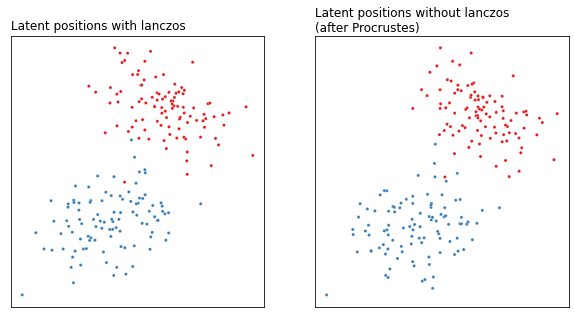

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

plot_latents(latents, ax=axs[0], title="Latent positions with lanczos", labels=labels)
plot_latents(latents_old_, ax=axs[1], title="Latent positions without lanczos \n(after Procrustes)", labels=labels)

### Frobenius norm of the difference

In [25]:
# before Procesutes
np.linalg.norm(latents - latents_old)

1.8576271635505623

In [24]:
# after Procrustes
np.linalg.norm(latents - latents_old_)

0.1471912090456788